## CHALLENGE DATA : Déterminer le chiffre d’affaire chez un marchand de vin

In [1]:
import pandas as pd
import xlrd
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt

df_erp = pd.read_excel(r'ressources_data/erp.xlsx')
df_web = pd.read_excel(r'ressources_data/web.xlsx')
df_liaison = pd.read_excel(r'ressources_data/liaison.xlsx')



C:\Users\utilisateur\anaconda3\lib\site-packages\openpyxl\worksheet\_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
C:\Users\utilisateur\anaconda3\lib\site-packages\openpyxl\worksheet\_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
C:\Users\utilisateur\anaconda3\lib\site-packages\openpyxl\worksheet\_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


**Faire un rapprochement entre l’export de la table de CMS  et l’export de l’ERP**


In [2]:
merged = pd.merge(df_erp, df_liaison, on=["product_id", "product_id"])
full = merged.merge(df_web, left_on='id_web', right_on='sku')
full.head(2)


,product_id,onsale_web,price,stock_quantity,stock_status,id_web,sku,virtual,downloadable,rating_count,...,post_name,post_modified,post_modified_gmt,post_content_filtered,post_parent,guid,menu_order,post_type,post_mime_type,comment_count
0,3847,1,24.2,0,outofstock,15298,15298,0,0,0,...,pierre-jean-villa-saint-joseph-preface-2018,2019-12-30 09:30:29,2019-12-30 08:30:29,NaN,0.0,https://www.wine-spirit.fr/?post_type=product&...,0.0,product,NaN,0.0
1,3847,1,24.2,0,outofstock,15298,15298,0,0,0,...,pierre-jean-villa-saint-joseph-preface-2018,2019-12-30 09:30:29,2019-12-30 08:30:29,NaN,0.0,https://www.wine-spirit.fr/wp-content/uploads/...,0.0,attachment,image/jpeg,0.0


**Le client souhaite avoir le chiffre d’affaire par produit et le total
de chiffre d’affaire réalisé**

In [3]:
#nettoyage du dataframe, on garde les ventes concernants les produits seulements
full = full[full["post_type"] == "product"]
full = full.drop_duplicates()
#suppression des lignes où l'id_web n'est pas connu
full.drop(full[full['id_web'].isnull()].index, inplace=True)


#calcul du chiffre d'affaire et ajout d'une colonne 'CA'
full['CA'] = full.apply(lambda row: ( row['price'] * row['total_sales'] ),axis=1 )
full[['price','CA']]


,price,CA
0,24.2,145.2
2,34.3,0.0
4,20.8,0.0
6,14.1,42.3
8,46.0,0.0
...,...,...
9153,8.4,42.0
9155,27.5,0.0
9157,69.0,0.0
9159,54.8,0.0


In [4]:
full['CA'].sum()
print("Le chiffre d'affaire est de {}".format(full['CA'].sum()))

Le chiffre d'affaire est de 70568.6


**Calculs du zcore et des interquantiles**

In [5]:
full['zscore'] = stats.zscore(full['price'])
outliers = full[full['zscore'] > 2 ]

print("Ci dessous, la liste des produits vendus à prix fort : \n")
for row in outliers[['post_title','price']].index :
    print("{} - Prix : {} ".format(outliers['post_title'][row], outliers['price'][row]))
    




Ci dessous, la liste des produits vendus à prix fort : 

Zind-Humbrecht Riesling Grand Cru Rangen De Thann Clos Saint-Urbain 2017 - Prix : 100.0 
Zind-Humbrecht Pinot Gris Grand Cru Rangen De Thann Clos Saint-Urbain 2012 - Prix : 88.4 
Champagne Egly-Ouriet Grand Cru Millésimé 2008 - Prix : 225.0 
Champagne Egly-Ouriet Grand Cru Blanc de Noirs - Prix : 126.5 
Cognac Frapin VIP XO - Prix : 176.0 
Cognac Frapin Château de Fontpinot XO - Prix : 108.5 
Cognac Frapin Château de Fontpinot 1989 20 Ans d'Age - Prix : 157.0 
Cognac Frapin Cigar Blend - Prix : 104.0 
Château de Meursault Puligny-Montrachet 1er Cru Champ Canet 2014 - Prix : 109.6 
Domaine Des Croix Corton Grand Cru Les Grèves 2017 - Prix : 102.3 
Domaine Des Croix Corton Charlemagne Grand Cru 2016 - Prix : 137.0 
David Duband Charmes-Chambertin Grand Cru 2014 - Prix : 217.5 
Domaine des Comtes Lafon Volnay 1er Cru Santenots du Milieu 2014 - Prix : 105.0 
Domaine des Comtes Lafon Volnay 1er Cru Santenots du Milieu 2013 - Prix : 10

In [6]:
# First quartile (Q1)
Q1 = np.percentile(full['price'], 25, interpolation = 'midpoint')
  
# Third quartile (Q3)
Q3 = np.percentile(full['price'], 75, interpolation = 'midpoint')
  
# Interquartile range (IQR)
IQR = Q3 - Q1

print(IQR)

28.050000000000004


**Représentations graphiques des ventes**

In [7]:
#Calcul des outliers

outliers_min = Q1 - 1.5 * IQR    #-27.975
outliers_max = Q3 + 1.5 * IQR    #84.22

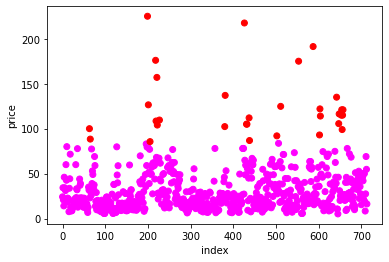

In [8]:
#création de nouveaux_index qui servent d'abcisse à la visualisation
indexs=[]
for i in range(len(full)):
    indexs.append(i)
full["new_index"]= indexs

#création d'une liste de couleurs . Outliers en rouge. 
colors =[] 
for row in full.index:
    if full['price'][row]>outliers_max:
        colors.append('red')  
    else:
        colors.append('magenta')

#Initiation et affichage d'un nuage de points
plt.scatter(full['new_index'] ,full['price'], c=colors)
plt.xlabel("index")
plt.ylabel("price")
plt.show()



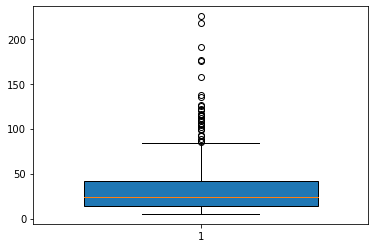

<Figure size 792x504 with 0 Axes>

In [9]:
D = full['price']

# plot
fig, ax = plt.subplots()
VP = ax.boxplot(D, widths=0.7, patch_artist=True)
fig = plt.figure(figsize =(11, 7))



plt.show()